In [1]:
from argparse import ArgumentParser
import os
import sys
import time

import dask.dataframe as dd
import dask_geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import shapely
import xarray as xr

# from matplotlib import colors
from pandarallel import pandarallel

sys.path.insert(1, '../scripts/')
from reaches import *
from utils import *

### Parse arguments

In [2]:
# FOR NOW, SET
width_set = 'min'

# Control flow
if width_set == 'mean':
    width = 'WidthM'
    binn = 'Bin'
elif width_set == 'min':
    width = 'WidthM_Min'
    binn = 'Bin_Min'
elif width_set == 'max':
    width = 'WidthM_Max'
    binn = 'Bin_Max'
else:
    print('Invalid width option specified, exiting.')
    # sys.exit()

In [3]:
huc2 = '01' ### SET THIS
data_path = '/nas/cee-water/cjgleason/data/SWOT/PIXC_v2_0_HUC2_' + huc2
# save_dir =

### Pixel Cloud

In [4]:
# Get job index
# slurm = int(os.environ['SLURM_ARRAY_TASK_ID'])
index = 106

In [5]:
huc2 = '01'
file_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/PIXC_v2_0_HUC2_' + huc2 + '_filtered.json'
data = open_json(file_path)

In [6]:
file_name = data[index]

In [7]:
# Get data for this tile
granule_name = file_name[:-3]
tile_name = file_name[20:28]
pass_num = int(file_name[20:23])

print(granule_name)

SWOT_L2_HR_PIXC_002_007_235R_20230811T080638_20230811T080649_PGC0_01


#### Read in PIXC

In [8]:
data_path

'/nas/cee-water/cjgleason/data/SWOT/PIXC_v2_0_HUC2_01'

In [9]:
# Set PIXC filepath
pixc_path = os.path.join(data_path, file_name)

In [10]:
# Read in pixel group
ds_PIXC = xr.open_mfdataset(paths=pixc_path, group = 'pixel_cloud', engine='h5netcdf')

In [11]:
# ds_PIXC

In [12]:
def bitwiseMask(ds):
    '''
    This function masks a PIXC granules: for now, it ony remove pixels
    with land classification and those with bad geolocation_qual.
    # See page 65 of PIXC PDD: https://podaac.jpl.nasa.gov/SWOT?tab=datasets-information&sections=about%2Bdata
    '''
    # Fow now, eliminate the really bad stuff
    mask = np.where((ds.classification > 1) & 
                    (ds.interferogram_qual < 2**7) & (ds.classification_qual < 2**7) &
                    (ds.geolocation_qual < 2**7) & (ds.sig0_qual < 2**7) &
                    (np.abs(ds.cross_track) > 10000) & (np.abs(ds.cross_track) < 60000))[0]
    
    print(mask.shape)
    return mask

In [13]:
# Make mask
mask = bitwiseMask(ds_PIXC)

if mask.shape[0] == 0:
    print('This granule has no pixels after masking, exiting.')
    # sys.exit(1)    

(742270,)


In [14]:
# Set desired data vars
variables = ['azimuth_index', 'range_index', 'cross_track',
             'pixel_area', 'height', 'geoid', 'prior_water_prob',
             'classification']

In [15]:
# Convert PIXC to GeoDataFrame
gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_vars=variables)

In [16]:
del ds_PIXC

### Find correct HUC4s

In [17]:
### NHDPlus HR
## Find correct HUC4s
# Read in tile and HUC4 intersection data
mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
dtype_dic= {'tile': str, 'huc4': str, 'coverage': float}
tile_huc4 = pd.read_csv(os.path.join(mdata_path,
                                    'huc4_swot_science_tiles.csv'),
                        dtype=dtype_dic)

In [18]:
# Make list of HUC4s that intersect the tile
hucs = list(tile_huc4[(tile_huc4['tile'] == tile_name)]['huc4'])
# Limit to the current HUC2
hucs = [x for x in hucs if x.startswith(huc2)]

In [19]:
hucs

['0101', '0102', '0105']

In [20]:
# # Get NHD index metadata
# # Define dtypes for lookup tables to preserve leading zeros
# dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
# # Read in HUC lookup table
# huc_lookup = pd.read_csv(os.path.join(mdata_path,
#                                   'HUC4_lookup_no_great_lakes.csv'),
#                      dtype=dtype_dic)

In [21]:
# # Extract indices for read-in
# indices = list(huc_lookup[huc_lookup['HUC4'].isin(hucs)]['slurm_index'])

### Read in buffered flowlines with extra

In [22]:
data_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_buffered_extra/HUC2_' + huc2 + '/'

In [23]:
file_paths = []

for huc in hucs:
    file_path = data_path + 'NHDPLUS_H_' + huc + '_HU4_GDB_prepped_buffered_extra_' + width_set + '.parquet'
    file_paths.append(file_path)

In [24]:
file_paths

['/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_buffered_extra/HUC2_01/NHDPLUS_H_0101_HU4_GDB_prepped_buffered_extra_min.parquet',
 '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_buffered_extra/HUC2_01/NHDPLUS_H_0102_HU4_GDB_prepped_buffered_extra_min.parquet',
 '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_buffered_extra/HUC2_01/NHDPLUS_H_0105_HU4_GDB_prepped_buffered_extra_min.parquet']

In [25]:
# # Create merged dataframe of all flowlines intersected
# if len(indices) == 1:
#     # Read prepped NHD
#     flowlines, _, _,  = readNHD(index=indices[0])
#     # huc4_list, huc2_list = readNHD(index=indices[0])
# else:
#     # Initialize lists
#     d = []
#     # huc4_list = []
#     # huc2_list = []
#     # Loop through indices and store in lists
#     for i in indices:
#         # Read prepped NHD
#         flowlines, _, _ = readNHD(index=i)
#         # huc4, huc2 = readNHD(index=i)
#         # Append to lists
#         d.append(flowlines)
#         # huc4_list.append(huc4) # I DON'T DO ANYTHING WITH THIS
#         # huc2_list.append(huc2) # I DON'T DO ANYTHING WITH THIS
#     # Merge GeoDataFrames
#     flowlines = pd.concat(d)

In [39]:
reach_mask = dask_geopandas.read_parquet(path=file_paths, columns=['NHDPlusID', 'buffers'])

In [40]:
reach_mask = reach_mask.compute()

In [41]:
reach_mask

,NHDPlusID,buffers
0,5.000100e+12,"POLYGON ((-7556065.155 5901238.694, -7556063.1..."
1,5.000100e+12,"POLYGON ((-7555956.36 5901220.07, -7555959.009..."
2,5.000100e+12,"POLYGON ((-7555456.182 5905189.369, -7555351.7..."
3,5.000100e+12,"POLYGON ((-7556267.55 5911622.722, -7556257.22..."
4,5.000100e+12,"POLYGON ((-7555177.369 5910114.686, -7555191.6..."
...,...,...
17740,5.000200e+12,"POLYGON ((-7554606.833 5613571.625, -7554479.7..."
17741,5.000200e+12,"POLYGON ((-7475728.83 5640963.938, -7475732.38..."
17742,5.000200e+12,"POLYGON ((-7585929.787 5615446.411, -7585869.3..."
17743,5.000200e+12,"POLYGON ((-7533892.664 5607799.685, -7533889.9..."


In [28]:
# # Project CRS (currently to WGS 84 / UTM zone 18N) 
# flowlines = flowlines.to_crs(epsg=3857)

In [29]:
# pandarallel.initialize(nb_workers=int(os.environ.get('SLURM_CPUS_PER_TASK')))

In [30]:
# start = time.time()
# # Args are the width, cap_style, segmented=False, extra=False
# # Buffering with extra distance to capture pixels that would overlap
# # once converted to pseudo-pixels
# flowlines['buffer'] = flowlines.parallel_apply(user_defined_function=specialBuffer,
#                                                          args=(width,
#                                                                'flat', False, True),
#                                                          axis=1)
# end = time.time()
# print(end - start)

In [31]:
# # Set geometry to buffered reaches
# flowlines = flowlines.set_geometry('buffer').set_crs(epsg=3857)

In [32]:
# flowlines.crs

In [44]:
# Clip masked pixels to buffered reaches
gdf_PIXC_clip = gpd.sjoin(gdf_PIXC, reach_mask, how='inner', predicate='within').reset_index().drop(columns=['index', 'index_right'])

In [113]:
# gdf_PIXC_clip

In [46]:
if gdf_PIXC_clip.shape[0] == 0:
    print('This granule has no pixels that intersect reaches, exiting.')
    # sys.exit() 

In [47]:
del gdf_PIXC, reach_mask

In [48]:
# # Drop unneeded cols
# gdf_PIXC_clip = gdf_PIXC_clip.drop(columns=['index_right', 'NHDPlusID',
#                                             'GNIS_Name', 'LengthKM',
#                                             'WidthM', 'WidthM_Min',
#                                             'WidthM_Max', 'Bin', 'Bin_Min',
#                                             'Bin_Max'#, 'geometry_right'
#                                            ])

In [ ]:
### STOPPED HERE 02-25-25

### Nadir track

In [65]:
# Get single pixel for selecting correct nadir segment
pixel_pt = gdf_PIXC_clip.iloc[0].geometry

In [66]:
# Find correct nadir segment and return its geometry
nadir_segment_ln = findNadir(pass_num=pass_num, pixel_pt=pixel_pt)

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


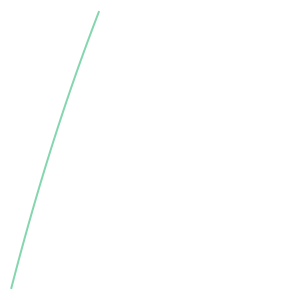

In [67]:
nadir_segment_ln

### Find alignment

In [68]:
az_nadir = calcAzimuth(line=nadir_segment_ln)

In [69]:
az_nadir

72.41249500094567

#### Read in flowlines

In [70]:
data_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped/HUC2_' + huc2 + '/'

In [71]:
file_paths = []

for huc in hucs:
    file_path = data_path + 'NHDPLUS_H_' + huc + '_HU4_GDB_prepped.parquet'
    file_paths.append(file_path)

In [72]:
fields = ['NHDPlusID', 'GNIS_Name', 'LengthKM', 'WidthM', 'WidthM_Min',
          'WidthM_Max', 'Bin', 'Bin_Min', 'Bin_Max', 'StreamOrde',
          'Slope', 'geometry']

In [97]:
flowlines = dask_geopandas.read_parquet(path=file_paths, columns=fields)

In [98]:
flowlines = flowlines.compute()

In [99]:
flowlines.loc[:,'geometry'] = flowlines.geometry.explode().force_2d()

In [100]:
pandarallel.initialize(nb_workers=int(os.environ.get('SLURM_CPUS_PER_TASK')))

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [101]:
def calcAzSin(df):
    # Set-up
    line = df.geometry
    x_coords = [coord[0] for coord in line.coords]
    y_coords = [coord[1] for coord in line.coords]
    
    # Regress
    result = linregress(x_coords, y_coords)
    slope = result.slope
    intercept = result.intercept
    
    # Find deltas
    dx = x_coords[-1] - x_coords[0]
    dy = y_coords[-1] - y_coords[0]
    dy_reg = (slope*x_coords[-1] + intercept) - y_coords[0]
    
    # Find azimuth
    azimuth = math.degrees(math.atan2(dy_reg, dx))
        
    if azimuth < 0:
        azimuth += 360
    
    # Find sinuosity
    distance = np.sqrt(dx**2 + dy**2)
    
    sinuosity = line.length/distance
    
    return azimuth, sinuosity

In [102]:
flowlines['temp'] = flowlines.parallel_apply(user_defined_function=calcAzSin, axis=1)

In [106]:
flowlines[['alignment', 'sinuosity']] = pd.DataFrame(flowlines['temp'].tolist(), index=flowlines.index)
flowlines = flowlines.drop(columns='temp')

### Make pseudo pixels

In [108]:
# Set along-track pixel resolution
azimuth_res = 22 # meters

In [109]:
# Make pseudo pixels
start = time.time()
gdf_PIXC_clip['pseudo_pixel'] = gdf_PIXC_clip.parallel_apply(user_defined_function=makePseudoPixels,
                                                         args=(nadir_segment_ln,
                                                               azimuth_res),
                                                         axis=1)
end = time.time()
print(end - start)

4.783907413482666


In [ ]:
# fig, ax = plt.subplots(figsize=(8,8))
# gdf_PIXC_clip.iloc[5:10]['pseudo_pixel'].plot(ax=ax, alpha=0.5, color='y')
# gdf_PIXC_clip.iloc[5:10].plot(ax=ax, markersize=5, color='hotpink')

In [110]:
# xxxWHY NOT JUST KEEP THE SAME DATA FRAME AND DROP THE UNWANTED COLS?
# pseudo = gdf_PIXC_clip.drop(columns='geometry').set_geometry('pseudo_pixel').set_crs(crs=gdf_PIXC_clip.crs)
gdf_PIXC_clip = gdf_PIXC_clip.rename(columns={'geometry': 'pixel_centroid'}).set_geometry('pseudo_pixel').set_crs(epsg=3857)

In [111]:
# Get bounds of PIXC tile
pseudo_bounds = gdf_PIXC_clip.total_bounds
# Copy geometry column as sjoin will discard it
gdf_PIXC_clip['pseudo_geom'] = gdf_PIXC_clip.geometry
# pseudo_poly = box(pseudo_bounds[0], pseudo_bounds[1],
#                       pseudo_bounds[2], pseudo_bounds[3])
# gdf_pseudo_bounds = gpd.GeoDataFrame({'geometry': [pseudo_bounds]}, crs=pseudo.crs)

In [112]:
gdf_PIXC_clip

,points,azimuth_index,range_index,cross_track,pixel_area,height,geoid,prior_water_prob,klass,latitude,longitude,pixel_centroid,NHDPlusID,pseudo_pixel,pseudo_geom
0,150,161.0,1229.0,22959.318359,561.194397,84.104378,-24.635891,0.00,2.0,45.388731,-67.751455,POINT (-7542057.427 5682928.174),5.000200e+12,"POLYGON ((-7542066.92 5682942.086, -7542072.58...","POLYGON ((-7542066.92 5682942.086, -7542072.58..."
1,151,161.0,1230.0,22985.056641,560.567139,81.963776,-24.636068,0.00,3.0,45.388843,-67.752044,POINT (-7542123.07 5682946.028),5.000200e+12,"POLYGON ((-7542132.549 5682959.937, -7542138.2...","POLYGON ((-7542132.549 5682959.937, -7542138.2..."
2,152,161.0,1231.0,23010.769531,559.941895,83.854668,-24.635729,0.00,2.0,45.388629,-67.750925,POINT (-7541998.523 5682912.155),5.000200e+12,"POLYGON ((-7542007.988 5682926.06, -7542013.65...","POLYGON ((-7542007.988 5682926.06, -7542013.65..."
3,155,161.0,1234.0,23089.482422,558.036499,78.806297,-24.636089,0.00,2.0,45.388856,-67.752111,POINT (-7542130.478 5682948.055),5.000200e+12,"POLYGON ((-7542139.901 5682961.949, -7542145.5...","POLYGON ((-7542139.901 5682961.949, -7542145.5..."
4,156,161.0,1235.0,23115.082031,557.419617,79.239677,-24.635937,0.00,2.0,45.388760,-67.751609,POINT (-7542074.596 5682932.858),5.000200e+12,"POLYGON ((-7542084.005 5682946.749, -7542089.6...","POLYGON ((-7542084.005 5682946.749, -7542089.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22747,1603195,1664.0,1050.0,15581.965820,826.227173,102.537430,-24.668346,0.63,4.0,45.689491,-67.732562,POINT (-7539954.27 5730728.765),5.000200e+12,"POLYGON ((-7539969.526 5730744.285, -7539975.2...","POLYGON ((-7539969.526 5730744.285, -7539975.2..."
22748,1603196,1664.0,1051.0,15619.209961,824.262390,102.532898,-24.668530,0.00,4.0,45.689402,-67.732096,POINT (-7539902.415 5730714.619),5.000200e+12,"POLYGON ((-7539917.628 5730730.127, -7539923.3...","POLYGON ((-7539917.628 5730730.127, -7539923.3..."
22749,1603197,1664.0,1052.0,15657.007812,822.277954,102.413261,-24.668684,0.00,3.0,45.689327,-67.731703,POINT (-7539858.667 5730702.685),5.000200e+12,"POLYGON ((-7539873.837 5730718.181, -7539879.5...","POLYGON ((-7539873.837 5730718.181, -7539879.5..."
22750,1603198,1664.0,1053.0,15694.713867,820.307739,102.315971,-24.668842,0.00,3.0,45.689250,-67.731297,POINT (-7539813.461 5730690.352),5.000200e+12,"POLYGON ((-7539828.587 5730705.837, -7539834.3...","POLYGON ((-7539828.587 5730705.837, -7539834.3..."


In [ ]:
# save_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/PIXC_v2_0_pseudo_pixels_filtered/'

In [ ]:
# gdf_PIXC.to_parquet(path=save_path + granule_name + '.parquet')

In [ ]:
## Stopped here 04/07/2025

### Read in segments

In [114]:
data_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented_buffered/HUC2_' + huc2 + '/'

In [118]:
file_paths = []

for huc in hucs:
    file_path = data_path + 'NHDPLUS_H_' + huc + '_HU4_GDB_prepped_segmented_buffered_' + width_set + '.parquet'
    file_paths.append(file_path)

In [119]:
file_paths

['/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented_buffered/HUC2_01/NHDPLUS_H_0101_HU4_GDB_prepped_segmented_buffered_min.parquet',
 '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented_buffered/HUC2_01/NHDPLUS_H_0102_HU4_GDB_prepped_segmented_buffered_min.parquet',
 '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented_buffered/HUC2_01/NHDPLUS_H_0105_HU4_GDB_prepped_segmented_buffered_min.parquet']

In [128]:
segments = dask_geopandas.read_parquet(path=file_paths)

In [130]:
segments = segments.compute()

In [ ]:
# # Create merged dataframe of all basins intersected
# if len(indices) == 1:
#     # Read prepped NHD
#     segments, _, _ = readNHD(index=indices[0], segmented=True)
# else:
#     # Initialize lists
#     d = []
#     # Loop through indices and store in lists
#     for i in indices:
#         # Read prepped NHD
#         segments, huc4, _ = readNHD(index=i, segmented=True)
#         # Make column with HUC4 id
#         segments['huc4_long'] = huc4
#         segments['huc4'] = segments['huc4_long'].str[10:14]
#         # Rename segments to geometry
#         # segments = segments.rename(columns={'segments': 'geometry'}).set_geometry('geometry')
#         # Append to list
#         d.append(segments)
#     # Merge GeoDataFrames
#     segments = pd.concat(d)

In [ ]:
# # Cast objects to string type so they aren't dropped in groupby()
# segments['Bin'] = segments['Bin'].astype('|S')
# segments['GNIS_Name'] = segments['GNIS_Name'].astype(str).str.encode('utf-8', errors='replace').str.decode('utf-8')

In [ ]:
# segments['GNIS_Name'] = segments['GNIS_Name'].astype('|S')

In [ ]:
# # Project CRS (currently to WGS 84 / UTM zone 18N)
# segments = segments.to_crs(epsg='3857')

In [134]:
segments = segments.reset_index().rename(columns={'index': 'index_old'})

In [135]:
# Assign a unique counter within each index group
segments['counter'] = segments.groupby('NHDPlusID').cumcount()

In [136]:
# Keep only first ten segments (some reaches repeat)
segments = segments[segments['counter'] < 10]

# For HUC4_0109, 5000700035256 and 5000700072690

In [137]:
segments

,index_old,NHDPlusID,GNIS_Name,LengthKM,WidthM,WidthM_Min,WidthM_Max,Bin,Bin_Min,Bin_Max,StreamOrde,Slope,buffers,counter
0,0,5.000100e+12,Everett Brook,0.073,4.859201,3.686081,6.405674,"(0, 10]","(0, 10]","(0, 10]",2,0.000685,"POLYGON ((-7556033.761 5901199.779, -7556033.6...",0
1,0,5.000100e+12,Everett Brook,0.073,4.859201,3.686081,6.405674,"(0, 10]","(0, 10]","(0, 10]",2,0.000685,"POLYGON ((-7556019.132 5901210.442, -7556016.9...",1
2,0,5.000100e+12,Everett Brook,0.073,4.859201,3.686081,6.405674,"(0, 10]","(0, 10]","(0, 10]",2,0.000685,"POLYGON ((-7556017.991 5901211.272, -7556010.8...",2
3,0,5.000100e+12,Everett Brook,0.073,4.859201,3.686081,6.405674,"(0, 10]","(0, 10]","(0, 10]",2,0.000685,"POLYGON ((-7556002.59 5901223.918, -7556000.25...",3
4,0,5.000100e+12,Everett Brook,0.073,4.859201,3.686081,6.405674,"(0, 10]","(0, 10]","(0, 10]",2,0.000685,"POLYGON ((-7555998.902 5901226.947, -7555995.2...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553465,17744,5.000200e+12,Whitten Parritt Stream,1.517,9.938574,7.539180,13.101593,"(0, 10]","(0, 10]","(10, 20]",3,0.003481,"POLYGON ((-7569970.752 5549350.56, -7569943.96...",5
553466,17744,5.000200e+12,Whitten Parritt Stream,1.517,9.938574,7.539180,13.101593,"(0, 10]","(0, 10]","(10, 20]",3,0.003481,"POLYGON ((-7569832.193 5549204.029, -7569824.2...",6
553467,17744,5.000200e+12,Whitten Parritt Stream,1.517,9.938574,7.539180,13.101593,"(0, 10]","(0, 10]","(10, 20]",3,0.003481,"POLYGON ((-7569681.363 5549136.179, -7569668.3...",7
553468,17744,5.000200e+12,Whitten Parritt Stream,1.517,9.938574,7.539180,13.101593,"(0, 10]","(0, 10]","(10, 20]",3,0.003481,"POLYGON ((-7569494.439 5549160.534, -7569493.9...",8


In [ ]:
segments = segments.clip(pseudo_bounds)

In [ ]:
# Keep only reaches that are fully contained in PIXC granule
segments = segments.groupby('NHDPlusID').filter(lambda x: len(x) == 10)

In [ ]:
len(segments['NHDPlusID'].unique())

In [ ]:
len(segments.sort_values(by=['NHDPlusID', 'counter'])[::10]['NHDPlusID'].unique())

In [ ]:
# Get number of reaches per bin
counts = pd.DataFrame(segments.sort_values(by=['NHDPlusID', 'counter'])[::10].Bin_Min.value_counts()).reset_index()

In [ ]:
counts

In [ ]:
# Buffer segments
## PARALLELIZE
start = time.time()
segments['buffer'] = segments.parallel_apply(user_defined_function=specialBuffer,
                                                         args=(width,
                                                               'flat', True, False),
                                                         axis=1)
end = time.time()
print(end - start)
# segments['buffered'] = segments.buffer(distance=(segments.WidthM/2), cap_style='flat')

In [ ]:
segments = segments.set_geometry('buffer').set_crs(epsg=3857)

In [ ]:
# Calculate segment area
segments['segment_area'] = segments.geometry.area

In [ ]:
# segments.sort_values(['NHDPlusID', 'counter'])

In [ ]:
# segments_buff = segments.geometry.buffer(distance=(segments.WidthM/2), cap_style='flat')

In [ ]:
# segment_bounds = segments_buff.bounds

In [ ]:
# ## Clip the pseudo pixels to the bounds of the reach
# pseudo_all = pseudo.union_all()

In [ ]:
# fig, ax = plt.subplots(figsize=(8,8))
# pseudo.plot(ax=ax, column='klass')
# segments.plot(ax=ax, color='k', alpha=0.6)
# plt.xlim(824000, 826000)
# plt.ylim(4741000, 4743000)

In [ ]:
segments.crs

In [ ]:
gpd.sjoin(segments, gdf_PIXC_clip, predicate='intersects')

In [ ]:
# Merge the segments and pseudo-puxels by intersection
sj = gpd.sjoin(segments, gdf_PIXC_clip, how='left', predicate='intersects')

In [ ]:
sj.columns

In [ ]:
sj = sj.drop(columns=['index_right', 'points', 'azimuth_index',
                      'range_index',
                      # 'height', 'geoid',
                      # 'klass',
                      'latitude', 'longitude'])

In [ ]:
sj

In [ ]:
sj = sj.set_geometry('pseudo_geom')

In [ ]:
sj = sj.groupby('NHDPlusID', as_index=False).parallel_apply(user_defined_function=specialDissolve)

In [ ]:
sj = sj.reset_index().drop(columns=['level_0', 'level_1'])

In [ ]:
sj['pseudo_geom_clip'] = sj.parallel_apply(user_defined_function=specialClip,
                                                         axis=1)

In [ ]:
# sj[sj['NHDPlusID'] == 10000900090399].pseudo_geom.plot(cmap='hsv')

In [ ]:
# Calculate the pseudo-pixel area within each node
sj['pseudo_area'] = sj.pseudo_geom_clip.area

In [ ]:
sj['coverage'] = sj.pseudo_area/sj.segment_area

In [ ]:
# sj_w_zero = sj.copy()

In [ ]:
# sj_w_zero['coverage'] = sj_w_zero['coverage'].fillna(0)
sj['coverage'] = sj['coverage'].fillna(0)

### Do stats

In [ ]:
bins = sj.Bin.unique()

#### Reaches

In [ ]:
reaches_cent, reaches_thresh, reaches_min = summarizeCoverage(df=sj, binn=binn,
                                            bins=bins, counts=counts)

In [ ]:
reaches_min

In [ ]:
reaches_min.sort_values(by=['NHDPlusID'])[::10]

In [ ]:
# d = {}
# # d_q = {}
# for i in range(1, 10):
#     threshold = i/10
#     # print(threshold)
    
#     detected = sj.groupby([binn, 'NHDPlusID'])['coverage'].apply(lambda x: (x > threshold).sum()) / 10
#     reach = detected.reset_index()
    
#     # reach = detected.groupby(binn).quantile(q=[x / 100.0 for x in range(0,100,1)]).reset_index()
        
#     d[threshold] = reach

In [ ]:
# Add a column for each DataFrame indicating the key
# for threshold, data in d.items():
#     data['threshold'] = threshold
    
for threshold, data in d.items():
    data['threshold'] = threshold

In [ ]:
# Concatenate all DataFrames into one
# reaches_desc = pd.concat(d.values())

reaches_cent = pd.concat(d.values()).rename(columns={'level_1': 'centile'})

In [ ]:
reaches_cent

In [ ]:
# reaches_cent = pd.merge(left=reaches_cent, right=counts, how='left', on=binn)

In [ ]:
reaches_cent

In [ ]:
reaches_min = pd.DataFrame(sj.groupby('NHDPlusID')['coverage'].min()).reset_index()

In [ ]:
reaches_min = pd.merge(left=reaches_min, right=sj[['NHDPlusID', binn]], how='left', on='NHDPlusID')

In [ ]:
min_cov

In [ ]:
# reaches = pd.DataFrame(data=d).T

In [ ]:
# reaches.columns = bins

### Write out

In [ ]:
save_path = os.path.join('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/', 'PIXC_v2_0_HUC2_01')

In [ ]:
# Combine node_desc
node_desc_both = pd.concat([node_desc, node_desc_w_zero], ignore_index=True)
node_desc_both

In [ ]:
# Combine node_quant
node_quant_both = pd.concat([node_quant, node_quant_w_zero], ignore_index=True)
node_quant_both

In [ ]:
# nodes_desc_both.to_csv(os.path.join(save_path, granule_name + '_nodes_describe.csv'))
# nodes_quant_both.to_csv(os.path.join(save_path, granule_name + '_nodes_quantile.csv'))

In [ ]:
# reaches_desc.to_csv(os.path.join(save_path, granule_name + '_reaches_describe.csv'))
# reaches_quant.to_csv(os.path.join(save_path, granule_name + '_reaches_quantile.csv'))

In [ ]:
test = pd.read_parquet('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_output/PIXC_v2_0_HUC2_01_2025_03_02_min/SWOT_L2_HR_PIXC_004_242_074L_20230930T103957_20230930T104008_PGC0_01_reaches_thresh.parquet')

In [ ]:
test